# Random Forest

## Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import datetime as dt
import os
import seaborn as sns
import random 
from scipy.optimize import newton
from scipy.stats import randint

In [155]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
sns.set_theme()
sns.set_palette("tab20")
sns.set_style("darkgrid", rc = {"grid.color": "white"})
c10 = sns.color_palette("tab10").as_hex()[:]
c20 = sns.color_palette("tab20").as_hex()[:]

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
os.chdir('/Users/maris/Documents/FE800')

## Import Data

In [10]:
df = pd.read_pickle("factor_df.pkl")
df = df.drop(["92976GAJ0", "902613AY4", "64110LAT3", "64110LAS5"])
df["Volume"] = df["Volume"].fillna(0)
df["Trades"] = df["Trades"].fillna(0)
df.head()

Price     Volume  Trades    Return       Age  \
cusip     trd_dt                                                      
00206RBH4 2018-07-02  86.132  2643000.0    13.0  0.000000  5.041096   
          2018-07-03  86.821    49000.0     7.0  0.007999  5.043836   
          2018-07-05  86.730   951000.0    24.0 -0.001048  5.049315   
          2018-07-06  88.675   678000.0    11.0  0.022426  5.052055   
          2018-07-09  89.397  2900000.0     7.0  0.008142  5.060274   

                            TTM  Stock_Return  Stock_Volume  ETF_Return  \
cusip     trd_dt                                                          
00206RBH4 2018-07-02  24.471233      0.000000    50002449.0    0.000000   
          2018-07-03  24.468493      0.015523    44857650.0   -0.005025   
          2018-07-05  24.463014     -0.003363    46895286.0    0.004959   
          2018-07-06  24.460274      0.002454    54541518.0    0.007858   
          2018-07-09  24.452055      0.004123    57539848.0    0.011967   

                            PV       YTM   Duration      DV01   Convexity  
cusip     trd_dt                                                           
00206RBH4 2018-07-02       NaN  0.054010  16.324665 -1.406076  339.273017  
          2018-07-03  0.004849  0.053445  16.343155 -1.418929  339.790490  
          2018-07-05  0.001749  0.053541  16.344714 -1.417577  339.812463  
          2018-07-06  0.001668  0.051959  16.349071 -1.449754  339.925850  
          2018-07-09 -0.002931  0.051410  16.326755 -1.459563  339.254704

In [11]:
scaler = StandardScaler()
scaled_volume, scaled_stock_volume = [], []

for i in df.index.droplevel(1).unique():
    scaled_volume.extend(scaler.fit_transform(df.loc[i][["Volume"]]))
    scaled_stock_volume.extend(scaler.fit_transform(df.loc[i][["Stock_Volume"]]))

df["Volume"] =  [item for sublist in scaled_volume for item in sublist]
df["Stock_Volume"] =  [item for sublist in scaled_stock_volume for item in sublist]
df.head()

Price    Volume  Trades    Return       Age        TTM  \
cusip     trd_dt                                                                
00206RBH4 2018-07-02  86.132 -0.169280    13.0  0.000000  5.041096  24.471233   
          2018-07-03  86.821 -0.779797     7.0  0.007999  5.043836  24.468493   
          2018-07-05  86.730 -0.567504    24.0 -0.001048  5.049315  24.463014   
          2018-07-06  88.675 -0.631757    11.0  0.022426  5.052055  24.460274   
          2018-07-09  89.397 -0.108793     7.0  0.008142  5.060274  24.452055   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
00206RBH4 2018-07-02      0.000000      0.043275    0.000000       NaN   
          2018-07-03      0.015523     -0.171355   -0.005025  0.004849   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749   
          2018-07-06      0.002454      0.232636    0.007858  0.001668   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931   

                           YTM   Duration      DV01   Convexity  
cusip     trd_dt                                                 
00206RBH4 2018-07-02  0.054010  16.324665 -1.406076  339.273017  
          2018-07-03  0.053445  16.343155 -1.418929  339.790490  
          2018-07-05  0.053541  16.344714 -1.417577  339.812463  
          2018-07-06  0.051959  16.349071 -1.449754  339.925850  
          2018-07-09  0.051410  16.326755 -1.459563  339.254704

In [21]:
macro_factors = pd.read_pickle("macro_factors.pkl").pct_change()
macro_factors = macro_factors.drop(["EFFR", "Lower_Target", "Upper_Target"], axis = 1)
macro_factors.head()

,1YRT,2YRT,3YRT,5YRT,7YRT,10YRT,30YRT,SPY,LQD
2018-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,-0.004274,-0.015564,-0.007547,-0.010909,-0.014134,-0.013937,-0.010033,-0.003531,0.003677
2018-07-05,-0.004292,0.007905,0.007605,0.007353,0.003584,0.003534,-0.003378,0.008158,0.003140
2018-07-06,0.008621,-0.007843,-0.003774,-0.010949,-0.007143,-0.007042,-0.003390,0.008458,0.001391
2018-07-09,0.000000,0.015810,0.007576,0.014760,0.014388,0.014184,0.006803,0.009004,0.000695


# Random Forest

In [143]:
def run_random_forest_no_tuning(df, feature):

    X = df.drop([feature, "Price"], axis=1)[1:].fillna(0)
    Y = df[feature][1:].fillna(0)

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    rf_model = RandomForestRegressor(n_estimators = 200)
    rf_model.fit(X_train, Y_train)
    
    Y_pred = rf_model.predict(X_test)
    r2_train = rf_model.score(X_train, Y_train)
    r2_test = r2_score(Y_test, Y_pred)

    prices = pd.DataFrame({"Test": df["Price"].loc[pd.Timestamp("2022-06-01"):]}).ffill()
    prices["Return Pred"] = Y_pred + 1

    pred = []
    for i in range(len(prices)):
        if i == 0:
            pred.append(prices["Return Pred"].iloc[0] * df["Price"].loc[pd.Timestamp("2022-05-31")])
        else:
            pred.append(prices["Return Pred"].iloc[i] * prices["Test"].iloc[i - 1])
    prices["Pred"] = pred
    
    mse = mean_squared_error(prices["Test"], prices["Pred"])
    rmse = mean_squared_error(prices["Test"], prices["Pred"], squared=False)
    mae = mean_absolute_error(prices["Test"], prices["Pred"])

    return r2_train, r2_test, mse, rmse, mae

In [144]:
%%time

run_random_forest_no_tuning(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]]
                             ,  macro_factors], axis = 1), "Return")

CPU times: user 2.15 s, sys: 35.8 ms, total: 2.19 s
Wall time: 2.19 s


(0.9118269989940462,
 0.3428118376128524,
 0.1699390144815671,
 0.412236600123724,
 0.29753171949747204)

In [127]:
def adjust_value(value):
    if abs(value) > 0.04:
        return 0.04 if value > 0 else -0.04
    else:
        return value

In [139]:
df_rf = df.copy()
df_rf["Return"] = df_rf["Return"].apply(adjust_value)
df_rf.head()

Price    Volume  Trades    Return       Age        TTM  \
cusip     trd_dt                                                                
00206RBH4 2018-07-02  86.132 -0.169280    13.0  0.000000  5.041096  24.471233   
          2018-07-03  86.821 -0.779797     7.0  0.007999  5.043836  24.468493   
          2018-07-05  86.730 -0.567504    24.0 -0.001048  5.049315  24.463014   
          2018-07-06  88.675 -0.631757    11.0  0.022426  5.052055  24.460274   
          2018-07-09  89.397 -0.108793     7.0  0.008142  5.060274  24.452055   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
00206RBH4 2018-07-02      0.000000      0.043275    0.000000       NaN   
          2018-07-03      0.015523     -0.171355   -0.005025  0.004849   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749   
          2018-07-06      0.002454      0.232636    0.007858  0.001668   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931   

                           YTM   Duration      DV01   Convexity  
cusip     trd_dt                                                 
00206RBH4 2018-07-02  0.054010  16.324665 -1.406076  339.273017  
          2018-07-03  0.053445  16.343155 -1.418929  339.790490  
          2018-07-05  0.053541  16.344714 -1.417577  339.812463  
          2018-07-06  0.051959  16.349071 -1.449754  339.925850  
          2018-07-09  0.051410  16.326755 -1.459563  339.254704

In [147]:
%%time

rf_results = pd.DataFrame(columns = ["Cusip", "R2 Train", "R2 Test", "MSE", "RMSE", "MAE"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_random_forest_no_tuning(pd.concat([df_rf.loc[col],  macro_factors], axis = 1), "Return")
    rf_results.loc[len(rf_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3], outputs[4]]

CPU times: user 25min 43s, sys: 21 s, total: 26min 4s
Wall time: 26min 4s


In [148]:
rf_results.head()

,Cusip,R2 Train,R2 Test,MSE,RMSE,MAE
0,00206RBH4,0.891701,-0.078038,1.202109,1.096407,0.842006
1,00206RBK7,0.881790,0.041262,0.932672,0.965750,0.731140
2,00206RCP5,0.879673,0.199956,0.738052,0.859100,0.658671
3,00206RCQ3,0.900236,0.212534,0.945815,0.972530,0.724285
4,00206RCU4,0.875843,-0.047359,2.341513,1.530200,0.890304


In [149]:
rf_results.sort_values("R2 Test", ascending = False).head()

,Cusip,R2 Train,R2 Test,MSE,RMSE,MAE
104,06051GHG7,0.893735,0.758081,0.049434,0.222337,0.173907
601,822582BQ4,0.919601,0.675803,0.287136,0.535850,0.403042
212,20030NCJ8,0.902695,0.671326,0.253746,0.503732,0.373387
674,913017BT5,0.923717,0.667190,0.310488,0.557214,0.413118
477,594918BS2,0.908088,0.664661,0.243002,0.492952,0.370788


In [150]:
rf_results.sort_values("R2 Test", ascending = True).head()

,Cusip,R2 Train,R2 Test,MSE,RMSE,MAE
127,10112RAY0,0.898450,-12.631188,4.121950,2.030259,1.870893
632,871829BF3,0.875616,-11.917150,3.306375,1.818344,1.478180
511,654106AF0,0.871429,-11.141041,2.395742,1.547818,1.307475
608,828807DC8,0.863380,-6.957036,1.975798,1.405631,1.301678
485,606822AJ3,0.844834,-6.320094,1.467952,1.211591,1.113850


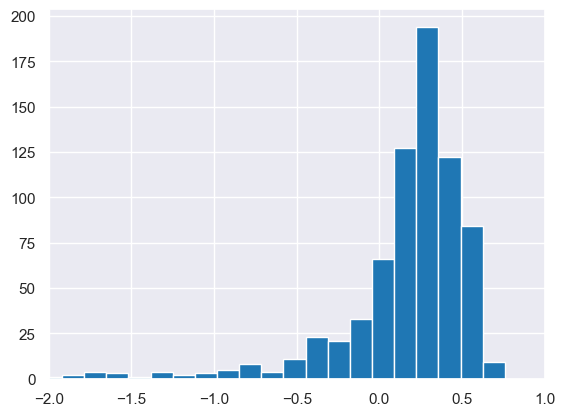

In [153]:
plt.hist(rf_results["R2 Test"], bins = 100)
plt.xlim(-2, 1)
plt.show()

In [154]:
rf_results.drop(["Cusip"], axis = 1).mean()

R2 Train    0.888731
R2 Test     0.003959
MSE         0.769469
RMSE        0.822621
MAE         0.594201
dtype: float64

# Gradient Boosting

In [157]:
def run_gradient_boosting_no_tuning(df, feature):
    
    X = df.drop([feature, "Price"], axis=1)[1:].fillna(0)
    Y = df[feature][1:].fillna(0)

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    gb_model = GradientBoostingRegressor(n_estimators=200)
    gb_model.fit(X_train, Y_train)
    
    Y_pred = gb_model.predict(X_test)
    r2_train = gb_model.score(X_train, Y_train)
    r2_test = r2_score(Y_test, Y_pred)

    prices = pd.DataFrame({"Test": df["Price"].loc[pd.Timestamp("2022-06-01"):]}).ffill()
    prices["Return Pred"] = Y_pred + 1

    pred = []
    for i in range(len(prices)):
        if i == 0:
            pred.append(prices["Return Pred"].iloc[0] * df["Price"].loc[pd.Timestamp("2022-05-31")])
        else:
            pred.append(prices["Return Pred"].iloc[i] * prices["Test"].iloc[i - 1])
    prices["Pred"] = pred
    
    mse = mean_squared_error(prices["Test"], prices["Pred"])
    rmse = mean_squared_error(prices["Test"], prices["Pred"], squared=False)
    mae = mean_absolute_error(prices["Test"], prices["Pred"])

    return r2_train, r2_test, mse, rmse, mae

In [168]:
%%time

run_gradient_boosting_no_tuning(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]]
                             ,  macro_factors], axis = 1), "Return")

CPU times: user 837 ms, sys: 19.6 ms, total: 857 ms
Wall time: 856 ms


(0.8959062089708116,
 0.07277100947925474,
 0.8648789997307545,
 0.9299887094641281,
 0.6986494658858609)

In [169]:
%%time

gb_results = pd.DataFrame(columns = ["Cusip", "R2 Train", "R2 Test", "MSE", "RMSE", "MAE"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_gradient_boosting_no_tuning(pd.concat([df_rf.loc[col],  macro_factors], axis = 1), "Return")
    gb_results.loc[len(gb_results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3], outputs[4]]

CPU times: user 9min 32s, sys: 7.17 s, total: 9min 39s
Wall time: 9min 39s


In [170]:
gb_results.head()

,Cusip,R2 Train,R2 Test,MSE,RMSE,MAE
0,00206RBH4,0.776600,-0.710634,1.902481,1.379304,1.153708
1,00206RBK7,0.773379,-0.220160,1.152217,1.073414,0.820380
2,00206RCP5,0.791217,0.054142,0.856990,0.925738,0.719927
3,00206RCQ3,0.798139,0.007562,1.166959,1.080259,0.837251
4,00206RCU4,0.788758,-0.142304,2.492724,1.578836,0.998919


In [172]:
gb_results.drop(["Cusip"], axis = 1).mean()

R2 Train    0.840578
R2 Test    -0.480093
MSE         1.039805
RMSE        0.950679
MAE         0.721153
dtype: float64

In [176]:
compare_error = pd.DataFrame(columns = ["R2 Train", "R2 Test", "MSE", "RMSE", "MAE"])
compare_error.loc["Random Forest"] = np.mean(rf_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error.loc["Gradient Boosting"] = np.mean(gb_results.drop(["Cusip"], axis = 1), axis = 0)
compare_error

,R2 Train,R2 Test,MSE,RMSE,MAE
Random Forest,0.888731,0.003959,0.769469,0.822621,0.594201
Gradient Boosting,0.840578,-0.480093,1.039805,0.950679,0.721153
